## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [84]:
# 1. Импорт библиотек

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


Загрузка всех необходимых библиотек

In [85]:
# 2. Импорт файла

taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Импорт файла

In [86]:
# 3. Визуальный осмотр данных

print (taxi.shape)
print (taxi.info())
display (taxi.describe())
display (taxi.head(5))


(26496, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

Визуальный осмотр файла: никаких аномалий не видно

# 2. Анализ

In [87]:
# 4. Ресемплирование к 1H

taxi = taxi.resample('1H').sum()
display (taxi.describe())
display (taxi.sort_values(by = 'num_orders', ascending = False).head(30))

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

num_orders
datetime                       
2018-08-20 02:00:00         462
2018-08-13 02:00:00         437
2018-08-27 02:00:00         408
2018-08-30 17:00:00         342
2018-08-27 04:00:00         295
2018-08-18 00:00:00         281
2018-08-26 00:00:00         281
2018-08-31 00:00:00         276
2018-08-13 01:00:00         273
2018-08-25 00:00:00         273
2018-08-20 04:00:00         273
2018-08-20 01:00:00         272
2018-08-31 04:00:00         268
2018-08-26 03:00:00         267
2018-08-29 23:00:00         265
2018-08-27 00:00:00         263
2018-08-18 02:00:00         254
2018-08-30 16:00:00         254
2018-04-24 00:00:00         253
2018-07-19 10:00:00         251
2018-08-11 00:00:00         249
2018-08-06 00:00:00         248
2018-08-24 00:00:00         247
2018-08-25 01:00:00         246
2018-08-30 23:00:00         246
2018-07-23 00:00:00         245
2018-08-24 22:00:00         242
2018-08-22 00:00:00         240
2018-08-21 01:00:00         239
2018-08-26 23:00:00         238

1. Ресемплировал все к 1H. Еще раз посмотрел визуально - все логично с точки зрения данных

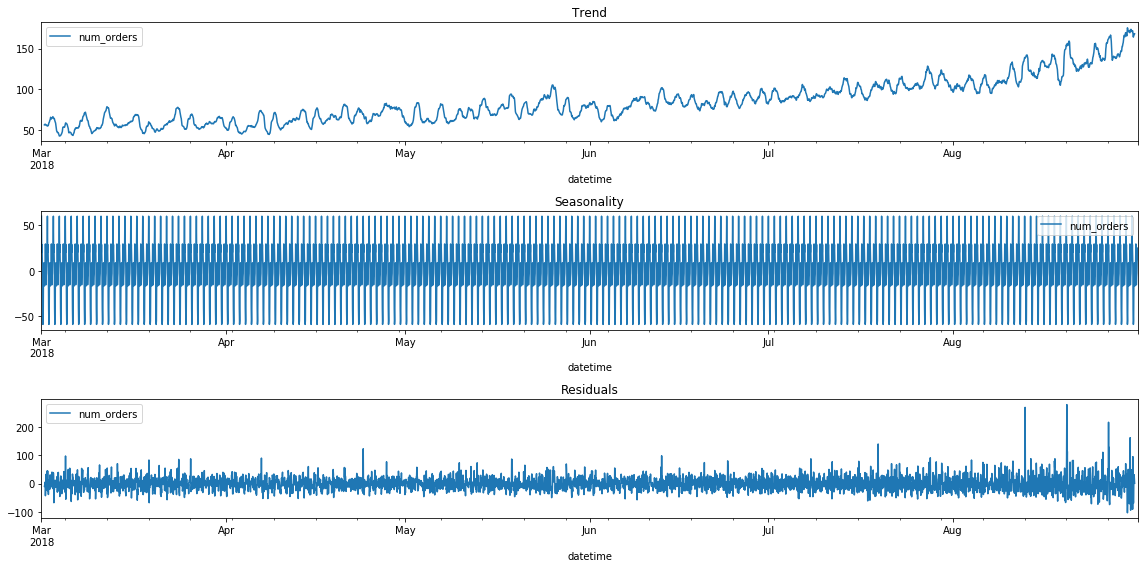

In [88]:
# 5. Декомпозиция и тренды

decomposed = seasonal_decompose(taxi) 

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

1. Виден общий тренд увеличения заказов - в конце года рост заказов в три раза по сравнению с началом года
2. Чтобы выявить сезонность - надо углубляться в анализ дальше

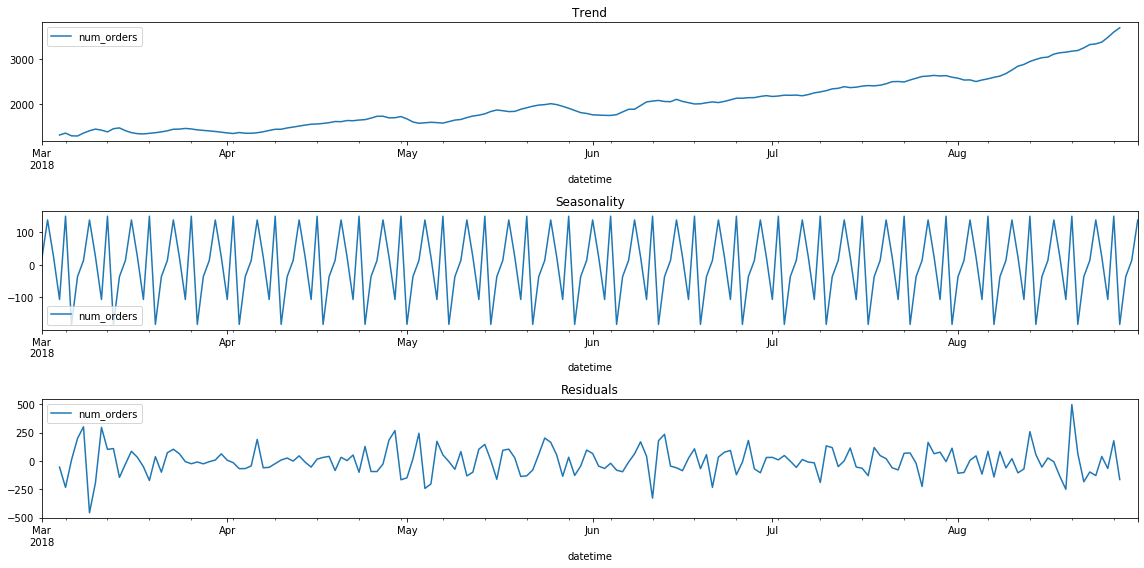

In [89]:
# 6. Декомпозиция по 1D

taxi1 = taxi.resample('1D').sum()

decomposed = seasonal_decompose(taxi1) 

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

1. Пока все то же самое. Будем углубляться дальше

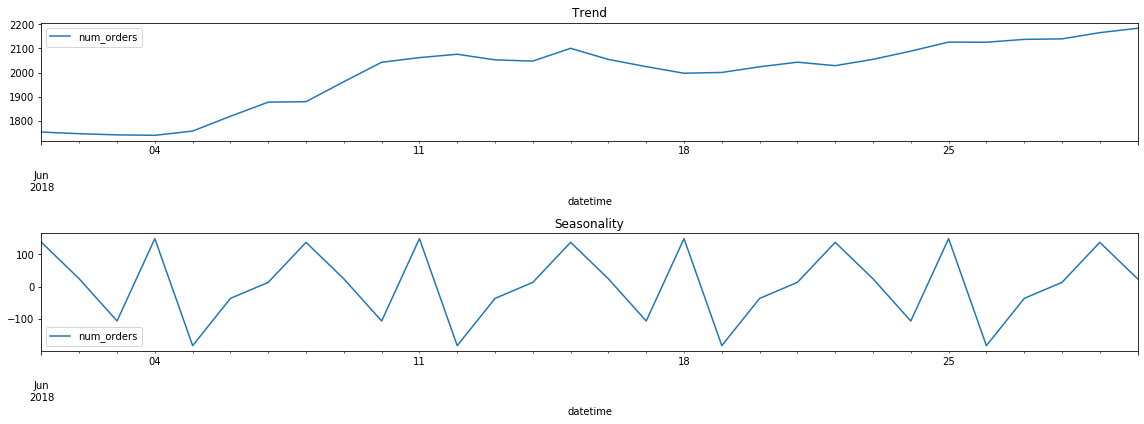

In [90]:
# 7. Декомпозиция по 1D - продолжение (по дням недели)

decomposed = seasonal_decompose(taxi1)

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

1. По дням недели - пики пятница и понедельник (для меня понедельник неожиданно).
2. Наименьшое количество заказов - вторник (очень странно) и воскресенье, что логично.

3. Добавил внутримесячный тренд, как доказательство необходимости создания столбца .day для обучения модели

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-03-31 19:00:00          70
2018-03-31 20:00:00          59
2018-03-31 21:00:00          53
2018-03-31 22:00:00          82
2018-03-31 23:00:00          63

[744 rows x 1 columns]

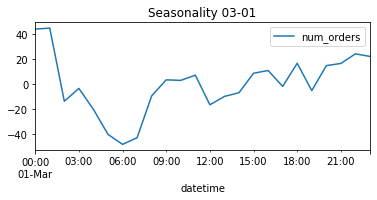

In [91]:
# 8. Декомпозиция по часам

taxi2 = taxi['2018-03-01':'2018-03-31']

display (taxi2)
decomposed = seasonal_decompose(taxi2) 

plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed.seasonal['2018-03-01-00':'2018-03-01-23'].plot(ax=plt.gca())
plt.title('Seasonality 03-01')
plt.show()


1. По часам - пик полночь, минимум 6 утра, далее постепенный рост.

In [92]:
# 9. Функция по созданию дополнительных столбцов

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



Создал функцию - по формированию дополнительных столбцов (декомпозиция даты и расчет скользящей средней) 
Ответы на комментарии:
1. Фактор - Год действительно не подходит, потому что для анализа нам предоставлены данные только в рамках одного года. Данный столбец удалю.
2. Фактор - Месяц. Несмотря на то, что каждый месяц у нас представлен только один раз, я оставлю данный параметр, так как значения в различных месяцах у нас все-таки отличаются, и вполне возможно, это поможет улучшить качество модели при ее обучении
3. Фактор - День. С одной стороны это просто последовательность чисел, с другой, например, возможно в начале месяца или конце, или середине - присутствуют некие закономерности, поэтому этот столбец также считаю полезным и оставляю. Например, в конце месяца - экономическая активность выше, следовательно должны чаще пользоваться услугами такси. Или, 5 или 10 числа, - день зарплаты - тоже самое. Это не так заметно на графике, там все перебивается днями недели, но все-таки, возможно, такая закономерность тоже есть.
Для этого при внутримесячном анализе добавил трендовый график, из которого четко видна внутримесячная динамика, не связанная с днями недели.
4. Фактор - день недели. Это уже объяснено на графике. Есть четкая зависимость от дня недели.
5. Фактор час - аналогично дню недели.
6. Фактор лаг - необходим для того, чтобы оценить влияние предыдущих значений ряда, на текущее значение. При обучении модели подбираем оптимальное количество столбцов, в которых учитываются предыдущие значения, при которых RMSE - наименьшее
7. Фактор rolling - рассчитываем скользящее среднее, предудущих значений и оцениваем влияние на качество модели.

# 3. Обучение

In [70]:

# 10. Линейная регрессия


rmse_min, lag_min, roll_min = 100000, 100000, 100000

for i in range (1,20,1):
    for j in range (1,20,1):
        
        make_features(taxi, i, j)


        train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
        train = train.dropna()

        features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
        target_train, target_test = train['num_orders'], test['num_orders']

        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)
        rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5
        if rmse_test < rmse_min:
            rmse_min = rmse_test
            lag_min = i
            roll_min = j
            
print("RMSE тестовой выборки: ", rmse_min, lag_min, roll_min)


'\n# 10. Линейная регрессия\n\n\nrmse_min, lag_min, roll_min = 100000, 100000, 100000\n\nfor i in range (1,20,1):\n    for j in range (1,20,1):\n        \n        make_features(taxi, i, j)\n\n\n        train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n        train = train.dropna()\n\n        features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n        target_train, target_test = train[\'num_orders\'], test[\'num_orders\']\n\n        model = LinearRegression()\n        model.fit(features_train, target_train)\n        predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)\n        rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5\n        if rmse_test < rmse_min:\n            rmse_min = rmse_test\n            lag_min = i\n            roll_min = j\n            \nprint("RMSE тестовой вы

RMSE линейной регрессии хуже таргета - 53.8. Продолжаем поиски оптимальной модели

In [71]:

# 11. Случайный лес

rmse_min, roll_min, est_min, depth_min = 100000, 0, 0, 0

for j in range (1,20,6):
    make_features(taxi, j, j)
    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
    target_train, target_test = train['num_orders'], test['num_orders']    
    for q in range (1,12,3):
        for z in range (1,300,15):
        
            model = RandomForestRegressor(random_state=12345, n_estimators=z, max_depth = q)
            model.fit(features_train, target_train)
            predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)
            rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5
            if rmse_test < rmse_min:
                rmse_min = rmse_test
                roll_min = j
                est_min = z
                depth_min = q
            print("RMSE тестовой выборки: ", rmse_test, j, z, q)    
print("лучшее RMSE тестовой выборки: ", rmse_min, roll_min, est_min, depth_min)


'\n# 11. Случайный лес\n\nrmse_min, roll_min, est_min, depth_min = 100000, 0, 0, 0\n\nfor j in range (1,20,6):\n    make_features(taxi, j, j)\n    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n    train = train.dropna()\n\n    features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n    target_train, target_test = train[\'num_orders\'], test[\'num_orders\']    \n    for q in range (1,12,3):\n        for z in range (1,300,15):\n        \n            model = RandomForestRegressor(random_state=12345, n_estimators=z, max_depth = q)\n            model.fit(features_train, target_train)\n            predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)\n            rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5\n            if rmse_test < rmse_min:\n                rmse_min = rmse_test\

Случайный лес показал требуемый результат - 43.14, но, может быть, можно лучше?

In [72]:

# 11. Попробуем чере градиент LGBM

rmse_min, roll_min, est_min, depth_min, leaves_min = 100000, 0, 0, 0, 0

for j in range (13,20,8):
    make_features(taxi, j, j)
    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
    target_train, target_test = train['num_orders'], test['num_orders']    
    for q in range (1,14,4):
        for z in range (1,300,60):
            for w in range (30,300,60):
        
                model = LGBMRegressor(loss_function='RMSE', n_iterations = z, max_depth = q, num_leaves = w, min_data_in_leaf = 3)
                model.fit(features_train, target_train)
                predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)
                rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5
                if rmse_test < rmse_min:
                    rmse_min = rmse_test
                    roll_min = j
                    est_min = z
                    depth_min = q
                    leaves_min = w
                print("RMSE тестовой выборки: ", rmse_test, j, z, q, w)    
print("лучшее RMSE тестовой выборки: ", rmse_min, roll_min, est_min, depth_min, leaves_min)


'\n# 11. Попробуем чере градиент LGBM\n\nrmse_min, roll_min, est_min, depth_min, leaves_min = 100000, 0, 0, 0, 0\n\nfor j in range (13,20,8):\n    make_features(taxi, j, j)\n    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n    train = train.dropna()\n\n    features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n    target_train, target_test = train[\'num_orders\'], test[\'num_orders\']    \n    for q in range (1,14,4):\n        for z in range (1,300,60):\n            for w in range (30,300,60):\n        \n                model = LGBMRegressor(loss_function=\'RMSE\', n_iterations = z, max_depth = q, num_leaves = w, min_data_in_leaf = 3)\n                model.fit(features_train, target_train)\n                predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)\n                rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squ

Это наилучший результат - 41.06

In [73]:

# 12. Еще на всякий случай проверим GridSearch


for j in range (1,20,6):
    make_features(taxi, j, j)
    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
    target_train, target_test = train['num_orders'], test['num_orders']

    time0 = time.time()
    param_grid = {'n_estimators' : [x for x in range(1,300,15)], 'max_depth': [x for x in range(1,15,3)]} 
    clf = GridSearchCV (estimator = RandomForestRegressor(), param_grid = param_grid, cv = 5, n_jobs = -1)
    clf.fit (features_train, target_train)
    predictions_test = clf.predict(features_test)
    rmse_test = (mean_squared_error(target_test, predictions_test))**0.5
    time1 = time.time()
    print("RMSE тестовой выборки: ", rmse_test, clf.best_params_, time1-time0)


'\n# 12. Еще на всякий случай проверим GridSearch\n\n\nfor j in range (1,20,6):\n    make_features(taxi, j, j)\n    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n    train = train.dropna()\n\n    features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n    target_train, target_test = train[\'num_orders\'], test[\'num_orders\']\n\n    time0 = time.time()\n    param_grid = {\'n_estimators\' : [x for x in range(1,300,15)], \'max_depth\': [x for x in range(1,15,3)]} \n    clf = GridSearchCV (estimator = RandomForestRegressor(), param_grid = param_grid, cv = 5, n_jobs = -1)\n    clf.fit (features_train, target_train)\n    predictions_test = clf.predict(features_test)\n    rmse_test = (mean_squared_error(target_test, predictions_test))**0.5\n    time1 = time.time()\n    print("RMSE тестовой выборки: ", rmse_test, clf.best_params_, time1-time0)\n'

Ожидаемый резльтат - близкий к RandomForest (очень долго отрабатывает)
Победитель LGBM с результатом RMSE - 41.06

In [93]:
#13 Модель с лучшими параметрами

make_features(taxi, 13, 13)
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
target_train, target_test = train['num_orders'], test['num_orders']    
model = LGBMRegressor(loss_function='RMSE', n_iterations = 61, max_depth = 5, num_leaves = 30, min_data_in_leaf = 3)
model.fit(features_train, target_train)
predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)

target_test1 = pd.DataFrame(target_test)
target_test1['predict'] = predictions_test


Запускаем модель с лучшими параметрами, чтобы впоследствии сделать графическую проверку результатов

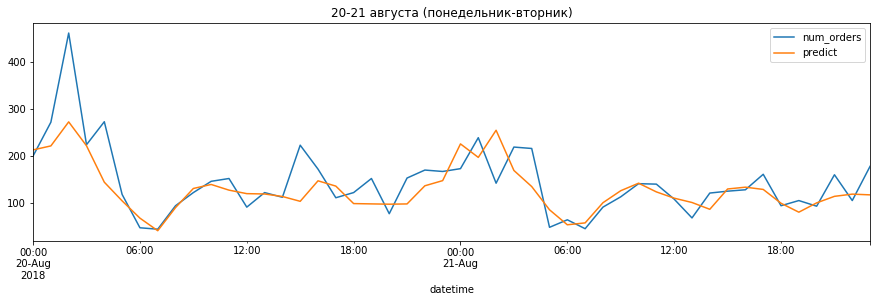

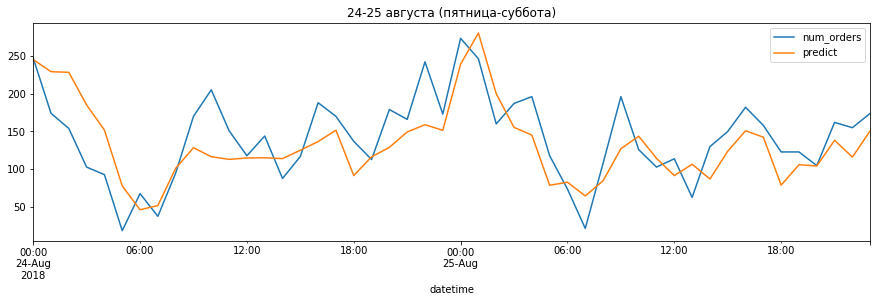

In [129]:
#14 Проверка на часовом графике

plt.figure(figsize=(15, 4))
target_test1['2018-08-20':'2018-08-21']['num_orders'].plot()
target_test1['2018-08-20':'2018-08-21']['predict'].plot()
plt.legend()
plt.title("20-21 августа (понедельник-вторник)")
plt.show()
plt.figure(figsize=(15, 4))
target_test1['2018-08-24':'2018-08-25']['num_orders'].plot()
target_test1['2018-08-24':'2018-08-25']['predict'].plot()
plt.legend()
plt.title("24-25 августа (пятница-суббота)")
plt.show()

1. Мне кажется, визуально, на часовом графике модель показывает себя достаточно неплохо.
2. Я специально сделал проверку и на рабочих днях (понедельник-вторник), и на выходных, предвыходных (пятница-суббота)
3. Основные тренды отлавливаются - провал к 6 утра, утренний пик (08-10 утра), ночной рост.
4. Что не ловится - резкие пики
5. Посмотрим, что происходит по дням недели

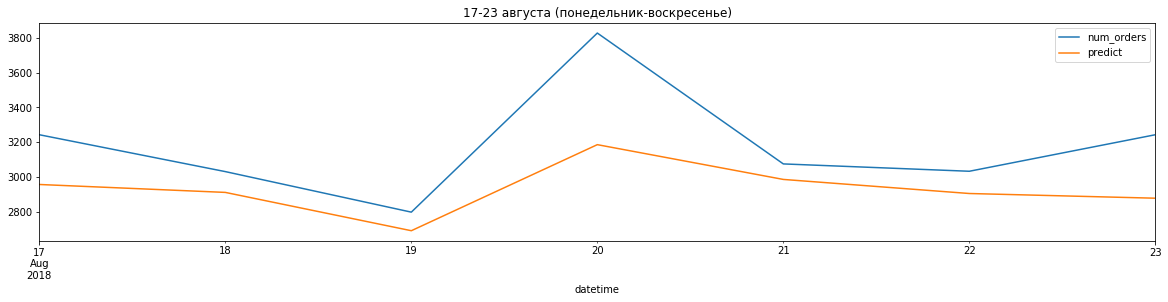

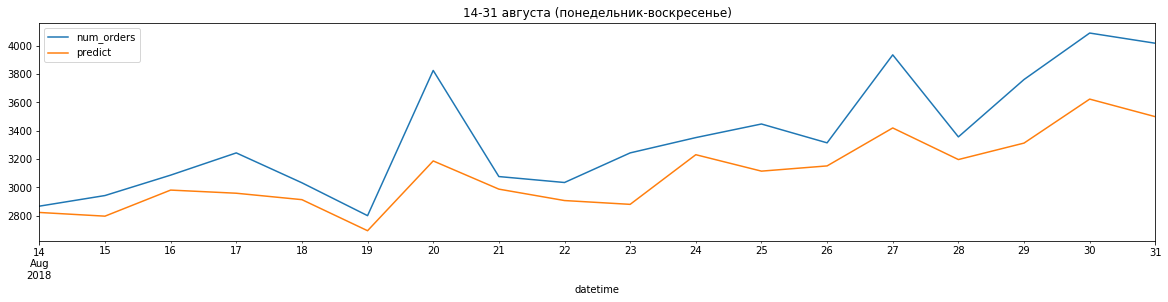

In [140]:
#15 Проверка на дневном графике

target_test2 = target_test1.resample('1D').sum()

plt.figure(figsize=(20, 4))
target_test2['2018-08-17':'2018-08-23']['num_orders'].plot()
target_test2['2018-08-17':'2018-08-23']['predict'].plot()
plt.legend()
plt.title("17-23 августа (понедельник-воскресенье)")
plt.show()

plt.figure(figsize=(20, 4))
target_test2['2018-08-14':'2018-08-31']['num_orders'].plot()
target_test2['2018-08-14':'2018-08-31']['predict'].plot()
plt.legend()
plt.title("14-31 августа (понедельник-воскресенье)")
plt.show()

Честно говоря, разочаровывающие данные
Кривая предсказаний находится значительно ниже фактической кривой
Конечно, 'сезонность' подтверждается. понедельник больше вторника и среды, рост к концу недели, но амплитуда совршенно не устраивает
Наверное, вы правы, это из-за того, что выборка у нас маленькая, и каждый месяц встречается только один раз, общий тренд на рост модель не схватывает?

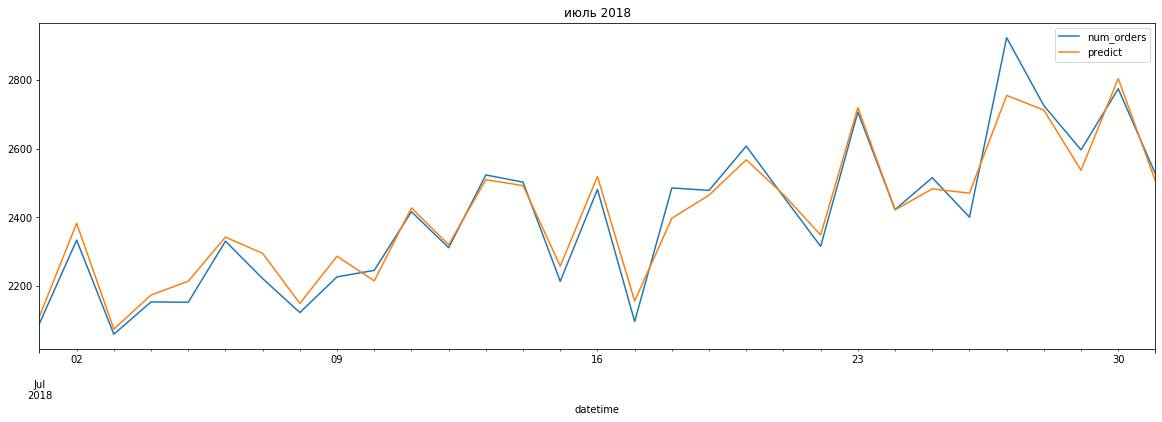

In [139]:
#16 Проверка на дневном графике (обучающая выборка)

target_train1 = pd.DataFrame(target_train)
target_train1['predict'] = predictions_train

target_train2 = target_train1.resample('1D').sum()

plt.figure(figsize=(20, 6))
target_train2['2018-07-01':'2018-07-31']['num_orders'].plot()
target_train2['2018-07-01':'2018-07-31']['predict'].plot()
plt.legend()
plt.title("июль 2018")
plt.show()

На обучающей выборке в месяц, предшествующий прогнозному - все выглядит адекватно.

# 4. Тестирование

По факту - все уже оттестировано

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48